In [8]:
import numpy as np
import pickle
from itertools import combinations
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from dataset import get_loaders

In [9]:
ax_order = 'first'
ax_order_str = 'axF'

In [10]:
with open('../../results/reg_%s_results_rnn.P' %(ax_order_str), 'rb') as f:
    rnn_results = pickle.load(f)
with open('../../results/reg_results_mlp.P', 'rb') as f:
    mlp_results = pickle.load(f)

In [11]:
data = get_loaders(batch_size=32, meta=False,
                    use_images=True, image_dir='../images/',
                    n_episodes=None)
train_data, train_loader, test_data, test_loader, analyze_data, analyze_loader = data
n_states = test_data.n_states 
loc2idx = test_data.loc2idx 
idxs = [idx for idx in range(n_states)]
locs = [loc for loc, idx in loc2idx.items()]


In [12]:
cp = -1

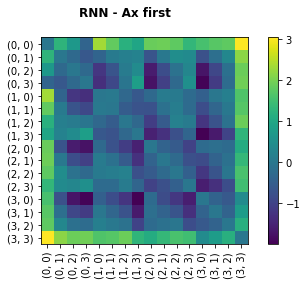

In [13]:
reg_results = rnn_results['reg_results']
cat_regs = reg_results['cat_regs']
con_regs = reg_results['con_regs']

y_hat_Es = con_regs['y_hat_Es'] # [runs, checkpoints, n_combinations]: [2, 11, 120]
ys = con_regs['ys'] 

wE = ys - y_hat_Es
wE = wE.mean(axis=0)[cp]


fig, axs = plt.subplots()
rsa_dist = np.zeros(shape=(n_states, n_states))
for i, (idx1, idx2) in enumerate(combinations(idxs, 2)):
    rsa_dist[idx1][idx2] = wE[i]
    rsa_dist[idx2][idx1] = wE[i]

plt.imshow(rsa_dist)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = '%s_rsa_rnn' %(ax_order_str)
fig.suptitle('RNN - Ax %s' %(ax_order), fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)


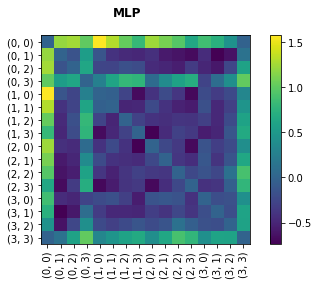

In [14]:
reg_results = mlp_results['reg_results']
cat_regs = reg_results['cat_regs']
con_regs = reg_results['con_regs']

y_hat_Es = con_regs['y_hat_Es'] # [runs, checkpoints, n_combinations]: [2, 11, 120]
ys = con_regs['ys'] 

wE = ys - y_hat_Es
wE = wE.mean(axis=0)[cp]


fig, axs = plt.subplots()
rsa_dist = np.zeros(shape=(n_states, n_states))
for i, (idx1, idx2) in enumerate(combinations(idxs, 2)):
    rsa_dist[idx1][idx2] = wE[i]
    rsa_dist[idx2][idx1] = wE[i]

plt.imshow(rsa_dist)
plt.xticks(idxs, locs, rotation='90')
plt.yticks(idxs, locs)
plt.colorbar()
fig_str = 'rsa_mlp'
fig.suptitle('MLP', fontweight='bold')
plt.tight_layout()   
fig.savefig(('../../figures/' + fig_str + '.pdf'),
            bbox_inches = 'tight', pad_inches=0)
